In [7]:
%matplotlib inline
import numpy as np
import torch
import time
import imageio.v3 as iio
import matplotlib.pyplot as plt

In [3]:
def bicubic_kernel(x, a=-0.5):
    """https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html#bicubic"""
    if abs(x) <= 1:
        return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
    elif 1 < abs(x) and abs(x) < 2:
        return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
    else:
        return 0

def build_filter(factor):
    size = factor*4
    k = np.zeros((size))
    for i in range(size):
        x = (1/factor)*(i- np.floor(size/2) +0.5)
        k[i] = bicubic_kernel(x)
    k = k / np.sum(k)
    k = np.outer(k, k.T)
    return torch.from_numpy(k).float()

def compute_H(image_size, factor, channels):
    H = build_filter(factor)
    res = torch.zeros(channels * image_size * image_size // factor // factor, channels * image_size * image_size)
    pad_top = (factor * 4 - factor) // 2

    def get_loc(c, i, j, sz):
        if i < 0:
            i = -i
        if j < 0:
            j = -j
        if i >= sz:
            i = (sz * 2 - 2) - i
        if j >= sz:
            j = (sz * 2 - 2) - j
        return (i * sz + j) + c * sz * sz

    for i in range(0, image_size // factor):
        for j in range(0, image_size // factor):
            for c in range(channels):
                loc_o = get_loc(c, i, j, image_size // 4)
                x, y = i * factor - pad_top, j * factor - pad_top
                for k in range(factor * 4):
                    for l in range(factor * 4):
                        loc_i = get_loc(c, x+k, y+l, image_size)
                        res[loc_o, loc_i] += H[k, l]           
    return res    



In [3]:
H_64 = compute_H(64, 4, 3)

In [4]:
start = time.time()
U, S, V = torch.svd(H_64, some=False)
end = time.time()
print(end - start)

1.7967946529388428


In [5]:
H_64 = H_64.cuda()

In [6]:
start = time.time()
U, S, V = torch.svd(H_64, some=False)
end = time.time()
print(end - start)

1.3902292251586914


In [6]:
H_128 = compute_H(128, 4, 3)

In [4]:
start = time.time()
U, S, V = torch.svd(H_128, some=False)
end = time.time()
print(end - start)

128.4071307182312


In [7]:
H_128 = H_128.cuda()

In [1]:
H_256 = compute_H(256, 4, 3)

NameError: name 'compute_H' is not defined

In [8]:
start = time.time()
U, S, V = torch.svd(H_128, some=False)
end = time.time()
print(end - start)

RuntimeError: cusolver error: CUSOLVER_STATUS_INVALID_VALUE, when calling `cusolverDnSgesvdj_bufferSize(handle, jobz, econ, m, n, A, lda, S, U, ldu, V, ldv, lwork, params)`

In [2]:
img = iio.imread('../images/thumbnail_image007.jpg')

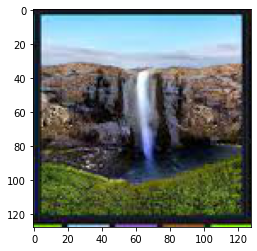

In [14]:
x, y = 0, 140
plt.imshow(img[x:x+128, y:y+128])

In [17]:
iio.imwrite('../images/gaugan_demo.jpg', img[x:x+128, y:y+128])